# Path planning with A*
The [A* algorithm](https://en.wikipedia.org/wiki/A*_search_algorithm) is a workhorse in many search problems where exhaustive search is not feasible or practical.  It is a simple extension of [Best-first search](https://en.wikipedia.org/wiki/Best-first_search) in which a heuristic is used to estimate the remaining cost-to-go for all open nodes.  In order to guarantee that `A*` will return the optimal solution, the heuristic must be [admissible](https://en.wikipedia.org/wiki/A*_search_algorithm#Admissibility_and_optimality); essentially, it must be never underestimate the cost-to-go.  In [path planning problems](https://en.wikipedia.org/wiki/Pathfinding), a subset of [graph search](https://en.wikipedia.org/wiki/Graph_traversal), a simple an clear heuristic is readily available: the [Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance) between the current position and the goal - there cannot be a shorter path.  

As possible paths between the current position and the goal are explored, partial paths are expanded in the order of their total estimated cost to the goal: the distance travelled so far + the estimated distance remaining.

## Algorithm Implementation

### World representation

In [1]:
class World(object):
    OBST = -1
    UNINITIALIZED = -2
    ON_HEAP = -3
    
    def __init__(self, height=10, width=10):
        self.map = np.ones((height, width)) * self.UNINITIALIZED
        self.robot = None
        self.goal = None
        
    @classmethod
    def random(cls, n=10, pct_obstacle=0.1):
        world = cls(n, n)
        for _ in xrange(int(pct_obstacle * n * n)):
            y, x = world.random_open_pos()
            world.map[y, x] = cls.OBST
        
        world.robot = 0, 0
        world.goal = n - 1, n - 1
        for pos in (world.robot, world.goal):
            world.map[pos] = world.UNINITIALIZED

        return world
    
    @classmethod
    def from_string(cls, string):
        rows = filter(None, [r.strip() for r in string.split('\n')])
        height = len(rows)
        width = len(rows[0])
        world = cls(height, width)
        for y, row in enumerate(rows):
            for x, val in enumerate(row):
                if val.lower() == 'x':
                    world.map[y, x] = cls.OBST
                elif val.lower() == 'r':
                    world.robot = y, x
                elif val.lower() == 'g':
                    world.goal = y, x
        return world
    
    def random_open_pos(self):
        while True:
            y = np.random.randint(len(self.map))
            x = np.random.randint(len(self.map[0]))
            if self.map[y, x] != self.OBST:
                return y, x
    
    def neighbors(self, y, x):
        for xx in xrange(max(0, x - 1), min(len(self.map[0]), x + 2)):
            for yy in xrange(max(0, y - 1), min(len(self.map), y + 2)):
                if self.map[yy, xx] != self.OBST and (yy, xx) != (y, x):
                    yield yy, xx
    
    @classmethod
    def distance(cls, p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))
    
    def plot(self, ax=None, path=None):
        if not ax:
            plt.figure(figsize=(12, 6))
            plt.axis('off')
            ax = plt.gca()
            obst_map = np.vectorize(lambda x: 0 if x == self.OBST else 255)(self.map)
            ax.imshow(obst_map, cmap='gray', interpolation='nearest') #, aspect='auto')
            ax.scatter(self.robot[1], self.robot[0], color='b', marker='D', s=30)
            ax.scatter(self.goal[1], self.goal[0], color='g', marker='D', s=30)

        path_points = np.where(self.map > 0)
        if path_points:
            ax.scatter(path_points[1], path_points[0], c=self.map[path_points], edgecolor='none', marker='o', cmap='RdYlGn')
            
        if path:
            y, x = zip(*path.path)
            ax.plot(x, y)
            
        return ax

## A* algorithm implementation

In [2]:
from Queue import PriorityQueue 

class Path(object):
    def __init__(self, path, cost_so_far, heuristic):
        self.path = path
        self.cost_so_far = cost_so_far
        self.heuristic = heuristic
        self.total_cost = cost_so_far + heuristic
        
    def valid(self, world):
        cost = 0
        for p1, p2 in zip(self.path, self.path[1:]):
            cost += world.distance(p1, p2)            
            if world.map[p2] != world.UNINITIALIZED and world.map[p2] < cost:
                return False
        return True
        
    def children(self, world):
        children = [Path(self.path + [step], 
                    self.cost_so_far + world.distance(step, self.path[-1]), 
                    world.distance(step, world.goal))
                    for step in world.neighbors(*self.path[-1]) if step not in self.path]
        return filter(lambda x: x.valid(world), children)
    
    def __cmp__(self, other):
        return -1 if self.total_cost < other.total_cost else 1
        

class Astar(object):
    def __init__(self, world):
        self.world = world
        self.best_path = None
        self.q = PriorityQueue()
        seed = Path([world.robot], 0, np.linalg.norm(np.array(world.robot) - np.array(world.goal)))
        self.q.put(seed)

    def next(self):
        p = self.q.get()
        
        # check to see if this node is still valid (have we seen another path
        # that passes through this path's end position)
        while not self.q.empty() and not p.valid(self.world):
            p = self.q.get()
            
        self.world.map[p.path[-1]] = p.cost_so_far
        
        if p.path[-1] == self.world.goal:
            self.best_path = p
        else:
            for child in p.children(self.world):
                self.q.put(child)
                
        return p

### Example
Let's take a peek at what a random world looks like after some exploration.  Each this cell is run, a new random map will be generated.  Some will not have solutions!

568 total steps


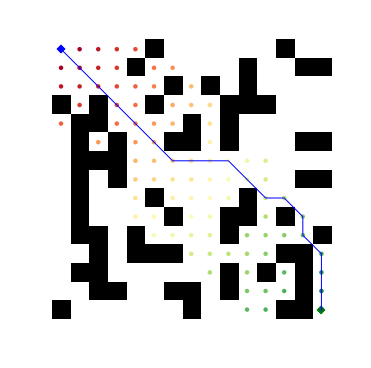

In [4]:
%matplotlib inline
astar = Astar(World.random(15, pct_obstacle=0.3))
p = astar.next()
for step in xrange(1000):
    p = astar.next()
    if astar.q.empty() or astar.best_path:
        break

astar.world.plot(path=p)
print step, 'total steps'

## Animation

In [6]:
from matplotlib import animation
import animembed

world = World.random(15, pct_obstacle=.3)
astar = Astar(world)
ax = astar.world.plot()

def init():
    astar.world.plot(ax)

def animate(frame_no):
    p = astar.next()
    astar.world.plot(ax, p)
        
def frames():
    frame = 0
    while not astar.best_path and frame < 1000:
        frame += 1
        yield frame
        
anim = animation.FuncAnimation(plt.gcf(), animate, init_func=init, frames=frames, save_count=1<<32)
animembed.display_animation(anim, fps=10)

In [ ]:
# save the gif if you like it!
anim.save('Astar.gif', writer='imagemagick', fps=15)